# Bugzilla Data for CI Tests on Testgrid

Currently, we are analyzing OpenShift CI test runs based on the raw run results data available on testgrid. However, we also want to analyze our CI process in terms of how many bugs we were able to discover, how severely these bugs impacted the product, how accurately did the tests pinpoint the problematic component, and so on. Additionally, having bug related data for the CI tests will also enable us to measure and track several KPIs.

Therefore, in this notebook we will connect the two data sources: Bugzilla and Testgrid. First, we will identify which bugs are linked with each failing test. Then, we will get detailed information regarding each of these bugs from Red Hat Bugzilla.

In [1]:
import sys
import requests
import datetime as dt
from io import StringIO
import multiprocessing as mp
from bs4 import BeautifulSoup

from tqdm import tqdm
from wordcloud import WordCloud
from dotenv import load_dotenv, find_dotenv

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import bugzilla

sys.path.insert(1, "../TestGrid/metrics")
from ipynb.fs.defs.metric_template import save_to_disk  # noqa: E402

In [2]:
# load env vars
load_dotenv(find_dotenv())

# tqdm extensions for pandas functions
tqdm.pandas()

# seaborn plot settings
sns.set(rc={"figure.figsize": (15, 5)})

In [3]:
# current datetime
current_dt = dt.datetime.now(tz=dt.timezone.utc)

In [4]:
# get the red hat dashboard names
response = requests.get(
    "https://testgrid.k8s.io/redhat-openshift-informing?id=dashboard-group-bar"
)
html = BeautifulSoup(response.content)
testgrid_script = html.findAll("script")[3]
testgrid_script = testgrid_script.text.split()[5].split(",")
dashboard_names = [x.split(":")[1] for x in testgrid_script if "name" in x]
dashboard_names

['"redhat-assisted-installer"',
 '"redhat-openshift-informing"',
 '"redhat-openshift-ocp-release-4.1-blocking"',
 '"redhat-openshift-ocp-release-4.1-informing"',
 '"redhat-openshift-ocp-release-4.2-blocking"',
 '"redhat-openshift-ocp-release-4.2-informing"',
 '"redhat-openshift-ocp-release-4.3-blocking"',
 '"redhat-openshift-ocp-release-4.3-broken"',
 '"redhat-openshift-ocp-release-4.3-informing"',
 '"redhat-openshift-ocp-release-4.4-blocking"',
 '"redhat-openshift-ocp-release-4.4-broken"',
 '"redhat-openshift-ocp-release-4.4-informing"',
 '"redhat-openshift-ocp-release-4.5-blocking"',
 '"redhat-openshift-ocp-release-4.5-broken"',
 '"redhat-openshift-ocp-release-4.5-informing"',
 '"redhat-openshift-ocp-release-4.6-blocking"',
 '"redhat-openshift-ocp-release-4.6-broken"',
 '"redhat-openshift-ocp-release-4.6-informing"',
 '"redhat-openshift-ocp-release-4.7-blocking"',
 '"redhat-openshift-ocp-release-4.7-broken"',
 '"redhat-openshift-ocp-release-4.7-informing"',
 '"redhat-openshift-ocp-re

## Get Linked Bugs

In this section, we will first identify the linked and associated bugs for all the tests for all jobs under a given dashboard. Then, for the bug ids obtained from this step, we will fetch detailed bug information and better understand the structure and properties of the bugzilla data in the next section. At the end of this section, we'll collect the linked and associated bugs for all tests under each of the jobs displayed on testgrid, and then save this dataset for further analysis in another notebook.

**NOTE** Running this procedure resulted in really long runtimes: ~30min for one job, >20hrs for all jobs. Therefore we parallelized the code and distributed the workload across multiple processes. This reduced the runtimes to ~1min and ~1hr respectively.

In [5]:
# manager to share objects across processes
manager = mp.Manager()

# number of max processes
n_max_processes = mp.cpu_count()

### Get Jobs under each Dashboard

In [6]:
# dict where key is dashboard name, value is list of jobs under that dashboard
dashboard_jobs_dict = manager.dict()


def get_jobs_in_dashboard(dj_dict_d_name_tuple):
    """Gets jobs listed under each dashboard.

    :param dj_dict_d_name_tuple: (tuple) Tuple where the first element is the
    shared dict where the result is to be stored and the second element is the
    dashboard name

    NOTE: If we want to have tqdm with a multiprocessing Pool, we need to use
    pool.imap and thus have only one arg passed. Otherwise we can also split
    the args into separate variables
    """
    # unpack args
    dj_dict, d_name = dj_dict_d_name_tuple

    # get list of jobs
    dj_dict[d_name] = tuple(
        requests.get(f"https://testgrid.k8s.io/{d_name}/summary").json().keys()
    )


# list of args to be passed to the function. each process will take one element
# from this list and call the function with it
args = []
for d in dashboard_names:
    args.append(tuple([dashboard_jobs_dict, d]))
args[0]

(<DictProxy object, typeid 'dict' at 0x7f8f4017c0a0>,
 '"redhat-assisted-installer"')

In [7]:
# spawn processes and run the function with each arg
with mp.Pool(processes=n_max_processes) as pool:
    _ = list(tqdm(pool.imap(get_jobs_in_dashboard, args), total=len(args)))

# sanity check
dashboard_jobs_dict._getvalue()['"redhat-openshift-ocp-release-4.2-informing"']

100%|██████████| 40/40 [00:02<00:00, 18.95it/s]


('periodic-ci-openshift-release-master-ci-4.2-e2e-aws-sdn-multitenant',
 'periodic-ci-openshift-release-master-ci-4.2-e2e-gcp',
 'periodic-ci-openshift-release-master-nightly-4.2-console-aws',
 'periodic-ci-openshift-release-master-nightly-4.2-e2e-aws-fips',
 'periodic-ci-openshift-release-master-nightly-4.2-e2e-aws-fips-serial',
 'periodic-ci-openshift-release-master-nightly-4.2-e2e-azure',
 'periodic-ci-openshift-release-master-nightly-4.2-e2e-azure-fips',
 'periodic-ci-openshift-release-master-nightly-4.2-e2e-azure-fips-serial',
 'periodic-ci-openshift-release-master-nightly-4.2-e2e-gcp',
 'periodic-ci-openshift-release-master-nightly-4.2-e2e-gcp-fips',
 'periodic-ci-openshift-release-master-nightly-4.2-e2e-gcp-fips-serial',
 'promote-release-openshift-machine-os-content-e2e-aws-4.1',
 'promote-release-openshift-machine-os-content-e2e-aws-4.2',
 'promote-release-openshift-machine-os-content-e2e-aws-4.2-s390x',
 'release-openshift-ocp-e2e-aws-scaleup-rhel7-4.2',
 'release-openshift-o

### Get Tests under each Job

In [8]:
# dict where key is (dashboard,job), value is list of tests under that job
job_tests_dict = manager.dict()


def get_tests_in_job(jt_dict_dj_pair_tuple):
    """Gets tests run under each job.

    :param jt_dict_dj_pair_tuple: (tuple) Tuple where the first element is the
    shared dict where the result is to be stored and the second element is a
    tuple of (dashboard, job)

    NOTE: If we want to have tqdm with a multiprocessing Pool, we need to use
    pool.imap and thus have only one arg passed. Otherwise we can also split
    the args into separate variables
    """
    # unpack args
    jt_dict, dj_pair = jt_dict_dj_pair_tuple

    # query testgrid for tests in dashboard, job
    ret = requests.get(
        f"https://testgrid.k8s.io/{dj_pair[0]}/table?&show-stale-tests=&tab={dj_pair[1]}"
    )

    # if valid response then add to dict, else print the names to debug
    if ret.status_code == requests.codes.ok:
        jt_dict[dj_pair] = [
            t["name"] for t in ret.json().get("tests")  # , [{'name': None}])
        ]
    else:
        print("non-successful status code for pair", dj_pair)
        jt_dict[dj_pair] = list()


# list of args to be passed to the function. each process will take one element
# from this list and call the function with it
# NOTE: itertools can be used instead of nested for, but this is more readable
args = []
for d, jobs in dashboard_jobs_dict.items():
    for j in jobs:
        args.append(
            tuple(
                [
                    job_tests_dict,  # first arg to function
                    (d, j),  # second arg to function
                ]
            )
        )
args[0]

(<DictProxy object, typeid 'dict' at 0x7f8e6c309bb0>,
 ('"redhat-assisted-installer"',
  'periodic-ci-openshift-release-master-nightly-4.6-e2e-metal-assisted'))

In [9]:
# spawn processes and run the function with each arg
with mp.Pool(processes=n_max_processes) as pool:
    _ = list(tqdm(pool.imap(get_tests_in_job, args), total=len(args)))

# sanity check
job_tests_dict._getvalue()[
    (
        '"redhat-openshift-ocp-release-4.2-informing"',
        "periodic-ci-openshift-release-master-ci-4.2-e2e-gcp",
    )
]

100%|██████████| 609/609 [00:38<00:00, 15.83it/s]


['Overall',
 'Operator results.operator conditions monitoring',
 'operator.Run multi-stage test e2e-gcp - e2e-gcp-ipi-install-install container test',
 'operator.Run multi-stage test e2e-gcp - e2e-gcp-gather-must-gather container test',
 'Pod',
 'operator.Run multi-stage test e2e-gcp',
 'job.initialize',
 'operator.Run multi-stage test e2e-*** - e2e-***-ipi-install-install container test',
 'Operator results.operator conditions image-registry',
 'Operator results.operator conditions authentication',
 'Operator results.operator conditions cloud-credential',
 'Operator results.operator conditions cluster-autoscaler',
 'Operator results.operator conditions console',
 'Operator results.operator conditions dns',
 'Operator results.operator conditions ingress',
 'Operator results.operator conditions insights',
 'Operator results.operator conditions kube-apiserver',
 'Operator results.operator conditions kube-controller-manager',
 'Operator results.operator conditions kube-scheduler',
 'Opera

### Get Linked Bugs under each Test for a Given Dashboard

In [10]:
# get bugs linked at timestamps up to this amount of time before today
max_age = "336h"

# ci details search url
url = "https://search.ci.openshift.org/"

sample_dashboard = '"redhat-openshift-ocp-release-4.2-informing"'

In [11]:
# dict where key is (dashboard, job, test), value is list of related bugs
djt_linked_bugs_dict = manager.dict()


def get_bugs_in_test(args_tuple):
    """Gets linked and associated bugs for each test+job.

    Queries the search.ci.openshift website just like the sippy setup does in
    its findBug function defined here:
    https://github.com/openshift/sippy/blob/1a44268082fc600d69771f95a96b4132c9b84285/pkg/buganalysis/cache.go#L230

    :param args_tuple: (tuple) Tuple where the first element is the
    shared dict where the result is to be stored and the second element is a
    tuple of (dashboard, job, test)

    NOTE: If we want to have tqdm with a multiprocessing Pool, we need to use
    pool.imap and thus have only one arg passed. Otherwise we can also split
    the args into separate variables
    """
    # unpack
    djt_linked_bugs, djt_tuple = args_tuple

    # search for linked and associated bugs for this test
    # DO NOT AJAX,MOBILE. THIS HACK PREVENTS REQUEST TIME OUT.
    # read more here - https://stackoverflow.com/a/63377265/9743348
    response = requests.post(
        "https://search.ci.openshift.org/",
        data={
            "type": "bug+junit",
            "context": "-1",
            "name": djt_tuple[1],
            "maxAge": "336h",
            "ajax": "true",
            "mobile": "false",
            "search": djt_tuple[2]
            .split(".", maxsplit=1)[-1]
            .replace("[", r"\[")
            .replace("]", r"\]"),
        },
    )
    soup = BeautifulSoup(response.content)

    # the "em" objects in soup have information that can tell us
    # whether or not this test had a linked bug for the given job name
    em_objects = soup.find_all("em")
    pct_affected = 0
    for em in em_objects:
        if "Found" in em.text:
            pct_affected = float(em.text.split()[2][:-1])
            break

    # init to empty for this test result / reset to empty from previous test result
    test_bugs = []

    # if percent jobs affected is 0 then the linked bugs correspond to another job
    if pct_affected > 0:
        result_rows = soup.find("table").find("tbody").find_all("tr")
        for row in result_rows:
            column_values = row.find_all("td")

            # if there is only 1 column then the result is a junit, not bug
            if len(column_values) > 1:
                # check the second column to make sure its a bug, not junit details
                if column_values[1].text == "bug":
                    test_bugs.append(column_values[0].text[1:])

    djt_linked_bugs[djt_tuple] = test_bugs


# list of args to be passed to the function. each process will take one element
# from this list and call the function with it
# NOTE: this double for loop can be done via itertools too but this is more readable
args = []
for djpair, tests in job_tests_dict.items():
    if djpair[0] == sample_dashboard:
        for t in tests:
            args.append(
                tuple(
                    [
                        djt_linked_bugs_dict,  # first arg to function
                        (*djpair, t),  # second arg to function
                    ]
                )
            )
args[0]

(<DictProxy object, typeid 'dict' at 0x7f8f22042d90>,
 ('"redhat-openshift-ocp-release-4.2-informing"',
  'periodic-ci-openshift-release-master-ci-4.2-e2e-aws-sdn-multitenant',
  'Overall'))

In [12]:
# spawn processes and run the function with each arg
with mp.Pool(processes=n_max_processes) as pool:
    _ = list(tqdm(pool.imap(get_bugs_in_test, args), total=len(args)))

# sanity check
djt_linked_bugs_dict._getvalue()[
    (
        '"redhat-openshift-ocp-release-4.2-informing"',
        "periodic-ci-openshift-release-master-ci-4.2-e2e-aws-sdn-multitenant",
        "Operator results.operator conditions monitoring",
    )
]

100%|██████████| 3581/3581 [00:39<00:00, 90.51it/s] 


['1936859']

In [13]:
# set of ALL bugs observed for this dashboard
all_bugs = set()

# flattened list. each element is (dashboard, job, test, list-of-bugs)
djt_linked_bugs_list = []
for k, v in djt_linked_bugs_dict.items():

    djt_linked_bugs_list.append(tuple([*k, v]))
    all_bugs.update(v)

# convert results to df
linked_bugs_df = pd.DataFrame(
    djt_linked_bugs_list, columns=["dashboard", "job", "test_name", "bug_ids"]
)

# drop rows where there are no linked bugs
has_linked_bugs = linked_bugs_df["bug_ids"].apply(len) > 0
print(
    f"Out of {len(has_linked_bugs)} rows, {has_linked_bugs.sum()} had non-empty linked bugs"
)
linked_bugs_df = linked_bugs_df[has_linked_bugs]

linked_bugs_df.head()

Out of 3581 rows, 64 had non-empty linked bugs


,dashboard,job,test_name,bug_ids
14,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,Operator results.operator conditions monitoring,[1936859]
18,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,job.initialize,"[1910801, 1927244, 1908880, 1914794, 1951808, ..."
60,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,Operator results.operator conditions monitoring,[1936859]
66,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,job.initialize,"[1880960, 1947067, 1915760, 1883991, 1851874, ..."
111,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-nightly-4...,Operator results.operator conditions monitoring,[1936859]


### Get Linked Bugs under each Test for All Dashboards

In [14]:
# init as empty dict. key is (dashboard, job, test) and value is the list of related bugs
djt_linked_bugs_dict = manager.dict()

# list of args to be passed to the function
# this time, we will get linked bugs for all tests in ALL dashboards, not just one
args = []
for djpair, tests in job_tests_dict.items():
    for t in tests:
        args.append(
            tuple(
                [
                    djt_linked_bugs_dict,  # first arg to function
                    (*djpair, t),  # second arg to function
                ]
            )
        )

# spawn processes and run the function with each arg
with mp.Pool(processes=n_max_processes) as pool:
    _ = list(tqdm(pool.imap(get_bugs_in_test, args), total=len(args)))

# flattened list. each element is (dashboard, job, test, list-of-bugs)
djt_linked_bugs_list = []
for k, v in djt_linked_bugs_dict.items():
    djt_linked_bugs_list.append(tuple([*k, v]))

# convert results to df
linked_bugs_df = pd.DataFrame(
    djt_linked_bugs_list, columns=["dashboard", "job", "test_name", "bug_ids"]
)

100%|██████████| 338676/338676 [1:02:25<00:00, 90.41it/s] 


True

In [20]:
# drop rows where there are no linked bugs
has_linked_bugs = linked_bugs_df["bug_ids"].apply(len) > 0
print(
    f"Out of {len(has_linked_bugs)} rows, {has_linked_bugs.sum()} had non-empty linked bugs"
)
linked_bugs_df = linked_bugs_df[has_linked_bugs]

# save df
save_to_disk(
    linked_bugs_df,
    "../../../data/raw/",
    f"linked-bugs-{current_dt.year}-{current_dt.month}-{current_dt.day}.parquet",
)

Out of 338676 rows, 8225 had non-empty linked bugs


True

## Get Bugzilla Details

In this section, we will get details for the bug ids collected for the sample dashboard in the above section. We will fetch all the available metadata fields for each bug, and but only explore the values in some of these fields. We will perform the meticulous exploratory analysis for all of the available Bugzilla fields in a future notebook. 

In [15]:
# connector object to talk to bugzilla
bzapi = bugzilla.Bugzilla("bugzilla.redhat.com")

# look at a sample bug - what properties does this object have?
samplebug = bzapi.getbug(1883345)
vars(samplebug).keys()

dict_keys(['bugzilla', '_rawdata', 'autorefresh', '_aliases', 'priority', 'cf_last_closed', 'creator', 'blocks', 'assigned_to_detail', 'last_change_time', 'comments', 'is_cc_accessible', 'keywords', 'creator_detail', 'cc', 'see_also', 'groups', 'assigned_to', 'url', 'qa_contact', 'creation_time', 'whiteboard', 'id', 'depends_on', 'cf_target_upstream_version', 'docs_contact', 'description', 'qa_contact_detail', 'resolution', 'classification', 'cf_doc_type', 'alias', 'op_sys', 'target_release', 'status', 'cc_detail', 'cf_clone_of', 'external_bugs', 'summary', 'is_open', 'platform', 'severity', 'cf_environment', 'flags', 'version', 'tags', 'component', 'sub_components', 'is_creator_accessible', 'cf_release_notes', 'product', 'target_milestone', 'is_confirmed', 'components', 'versions', 'sub_component', 'fixed_in', 'weburl'])

**NOTE** The above shows what fields/properties related to each bugzilla we have available.
Upon a bit of investigating we found that
- `_rawdata` just contains the information already captured in other fields in a json format, and thus is redundant
- `bugzilla` attribute is depracated / old representation used in the python-bugzilla library, and thus is not useful for analysis
- `_aliases` is a mapping of synonyms for some of the fields, and thus is not useful for analysis
- The following properties didn't exist for most bugs (it's not that these properties has empty values, it's that the properties themselves didn't exist as a field for most objects of the Bugzilla class):
    - `qa_contact_detail`
    - `cf_last_closed`
    - `cf_clone_of`

In [16]:
# get all the available fields, except the depracated and duplicate ones
bug_details_to_get = list(vars(samplebug).keys())
bug_details_to_get.remove("_rawdata")
bug_details_to_get.remove("bugzilla")
bug_details_to_get.remove("_aliases")

# these two keys are msissing for a lot of bugs
bug_details_to_get.remove("qa_contact_detail")
bug_details_to_get.remove("cf_last_closed")
bug_details_to_get.remove("cf_clone_of")

bug_details_to_get

['autorefresh',
 'priority',
 'creator',
 'blocks',
 'assigned_to_detail',
 'last_change_time',
 'comments',
 'is_cc_accessible',
 'keywords',
 'creator_detail',
 'cc',
 'see_also',
 'groups',
 'assigned_to',
 'url',
 'qa_contact',
 'creation_time',
 'whiteboard',
 'id',
 'depends_on',
 'cf_target_upstream_version',
 'docs_contact',
 'description',
 'resolution',
 'classification',
 'cf_doc_type',
 'alias',
 'op_sys',
 'target_release',
 'status',
 'cc_detail',
 'external_bugs',
 'summary',
 'is_open',
 'platform',
 'severity',
 'cf_environment',
 'flags',
 'version',
 'tags',
 'component',
 'sub_components',
 'is_creator_accessible',
 'cf_release_notes',
 'product',
 'target_milestone',
 'is_confirmed',
 'components',
 'versions',
 'sub_component',
 'fixed_in',
 'weburl']

In [17]:
# create a df containing details of all linked and associated bugs
bugs_df = pd.DataFrame(
    columns=["bug_id"] + bug_details_to_get, index=range(len(all_bugs))
)
bugs_df = bugs_df.assign(bug_id=all_bugs)
bugs_df.head()

,bug_id,autorefresh,priority,creator,blocks,assigned_to_detail,last_change_time,comments,is_cc_accessible,keywords,...,is_creator_accessible,cf_release_notes,product,target_milestone,is_confirmed,components,versions,sub_component,fixed_in,weburl
0,1936780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1866023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1901472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1772295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1905680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
def fill_bug_details(bug_row):
    """
    Populate details for each bug
    """
    global bzapi

    try:
        bug = bzapi.getbug(bug_row.bug_id)
    except Exception:
        return bug_row

    for detail in bug_row.index:
        try:
            bug_row[detail] = getattr(bug, detail)
        except AttributeError:
            print(detail)

    return bug_row


bugs_df.progress_apply(fill_bug_details, axis=1)
bugs_df.head()

100%|██████████| 2957/2957 [32:38<00:00,  1.51it/s]  


,bug_id,autorefresh,priority,creator,blocks,assigned_to_detail,last_change_time,comments,is_cc_accessible,keywords,...,is_creator_accessible,cf_release_notes,product,target_milestone,is_confirmed,components,versions,sub_component,fixed_in,weburl
0,1936780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1866023,False,medium,Noam Manos,[],"{'real_name': 'Harshal Patil', 'email': 'harpa...",20201211T04:08:02,"[{'is_private': False, 'count': 0, 'creator': ...",True,[Reopened],...,True,,OpenShift Container Platform,---,True,[Node],[4.4],Kubelet,,https://bugzilla.redhat.com/show_bug.cgi?id=18...
2,1901472,False,high,Martin André,[],"{'real_name': 'Martin André', 'email': 'm.andr...",20210224T15:36:19,"[{'is_private': False, 'count': 0, 'creator': ...",True,[UpcomingSprint],...,True,,OpenShift Container Platform,---,True,[Machine Config Operator],[4.7],,,https://bugzilla.redhat.com/show_bug.cgi?id=19...
3,1772295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1905680,False,high,Mike Fiedler,[1906033],"{'real_name': 'OVN Team', 'email': 'ovnteam', ...",20210127T10:43:37,"[{'is_private': False, 'count': 0, 'creator': ...",True,[],...,True,,Red Hat Enterprise Linux Fast Datapath,---,True,[ovn2.13],[RHEL 8.0],,,https://bugzilla.redhat.com/show_bug.cgi?id=19...


In [115]:
# custom converting each column into a dtype that pyarrow can work with is tricky
# as a hack, we'll convert the df to a csv (in a buffer) and then read that csv
# so that pandas does the type comprehension by itself
buffer = StringIO()
bugs_df.to_csv(buffer, index=False)

buffer.seek(0)
bugs_df = pd.read_csv(buffer)

# save raw data
save_to_disk(
    bugs_df,
    "../../../data/raw/",
    f"bug-details-{current_dt.year}-{current_dt.month}-{current_dt.day}.parquet",
)

True

## Inspect Bug Metadata

In this section, we will look into some of the metadata fields available in bugzilla. We will not go through every field, but rather the ones that seem more important features of a bug.

To learn more about what each of these fields represents, please check out the official docs at [Bugzilla](https://bugzilla.readthedocs.io/en/latest/using/understanding.html), [Red Hat Bugzilla](https://bugzilla.redhat.com/docs/en/html/using/understanding.html), or [python-bugzilla](https://github.com/python-bugzilla/python-bugzilla/blob/82972796cf04f1ac06525670c272465a66d77da1/man/bugzilla.rst#global-options).

### priority

The priority field is used to prioritize bugs, either by the assignee, or someone else with authority to direct their time such as a project manager.

In [116]:
vc = bugs_df["priority"].value_counts()
vc

unspecified    945
high           702
medium         637
low            267
urgent         264
Name: priority, dtype: int64

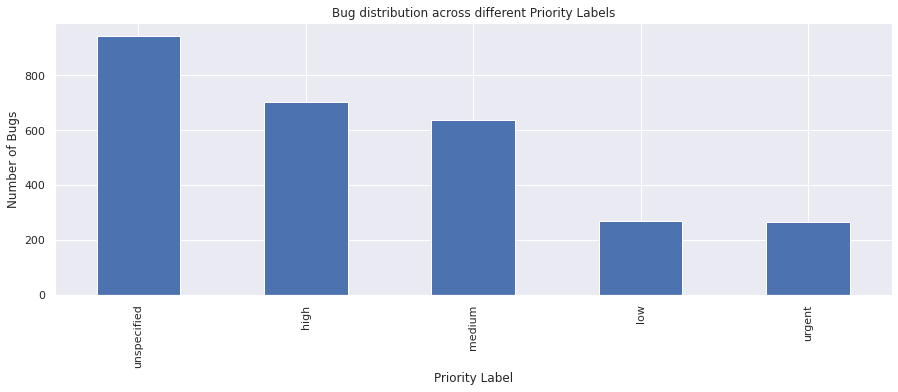

In [117]:
vc.plot(kind="bar")
plt.xlabel("Priority Label")
plt.ylabel("Number of Bugs")
plt.title("Bug distribution across different Priority Labels")
plt.show()

### blocks
The blocks field lists the bugs that are blocked by this particular bug.

In [118]:
def get_n_blocked(blockedlist):
    try:
        return len(blockedlist)
    except TypeError:
        return 0


nblocked = bugs_df["blocks"].apply(get_n_blocked)
nblocked.value_counts()

2      2052
9       589
0       142
18      133
27       27
36        7
45        4
54        1
63        1
351       1
Name: blocks, dtype: int64

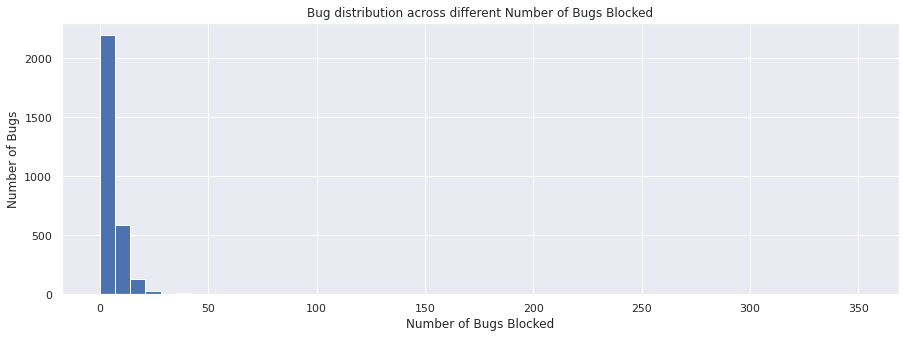

In [119]:
nblocked.plot(kind="hist", bins=50)
plt.xlabel("Number of Bugs Blocked")
plt.ylabel("Number of Bugs")
plt.title("Bug distribution across different Number of Bugs Blocked")
plt.show()

### last_change_time

In [120]:
last_change_time = pd.to_datetime(bugs_df["last_change_time"])
last_change_time

0                      NaT
1      2020-12-11 04:08:02
2      2021-02-24 15:36:19
3                      NaT
4      2021-01-27 10:43:37
               ...        
2952   2021-01-12 15:18:40
2953   2021-02-24 15:58:07
2954   2021-03-16 19:37:14
2955   2021-01-06 22:34:45
2956   2021-04-05 17:55:02
Name: last_change_time, Length: 2957, dtype: datetime64[ns]

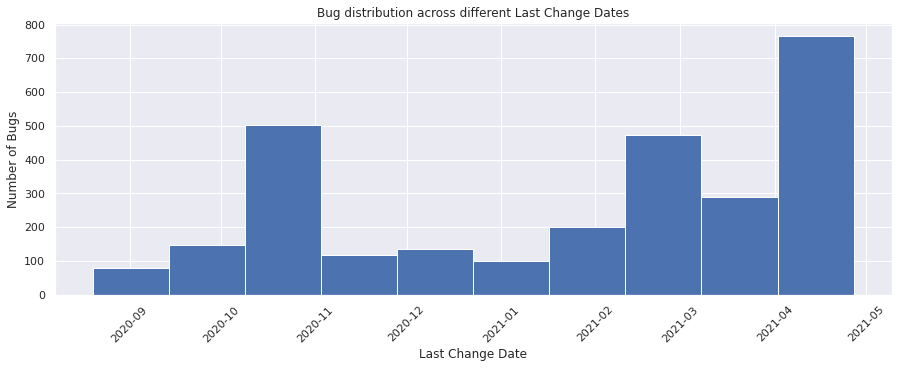

In [121]:
last_change_time.hist()
plt.xlabel("Last Change Date")
plt.ylabel("Number of Bugs")
plt.title("Bug distribution across different Last Change Dates")
plt.xticks(rotation=45)
plt.show()

### keywords

In [122]:
bugs_df["keywords"].value_counts()

[]                                                                                1966
['Reopened']                                                                       170
['Upgrades']                                                                       168
['UpcomingSprint']                                                                 123
['TestBlocker']                                                                     54
                                                                                  ... 
['Performance']                                                                      1
['Triaged', 'Upgrades']                                                              1
['RFE', 'UpcomingSprint']                                                            1
['Regression', 'ServiceDeliveryBlocker', 'UpgradeBlocker', 'Upgrades']               1
['Regression', 'Reopened', 'ServiceDeliveryImpact', 'TestBlocker', 'Upgrades']       1
Name: keywords, Length: 86, dtype: int64

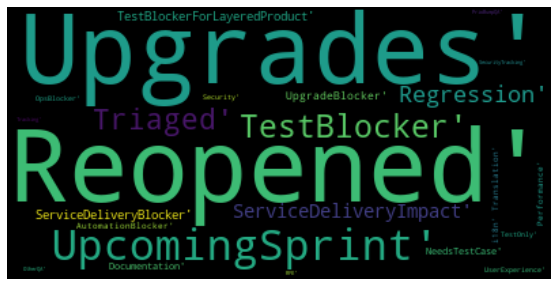

In [123]:
# wordcloud to get rough aggregated idea of which keywords occur the most
wordcloud = WordCloud(max_font_size=75, max_words=500).generate(
    bugs_df.keywords.str.cat()
)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Whiteboard
A free-form text area for adding short notes and tags to a bug.

In [124]:
vc = bugs_df["whiteboard"].value_counts()
vc

logging-exploration                          47
LifecycleStale                               36
LifecycleReset                               30
logging-core                                 20
Scrubbed                                     12
TechnicalReleaseBlocker                       9
multi-arch                                    8
aos-scalability-46                            8
UpdateRecommendationsBlocked                  7
SDN-CI-IMPACT                                 7
devex                                         7
non-multi-arch                                5
logging-exploration osd-45-logging            5
IBMROKS                                       5
AI-Team-Core                                  4
AI-Team-Platform                              3
aos-scalability-48                            2
component:jenkins-2-plugins                   2
workloads                                     2
47hack                                        2
aos-scalability-47                      

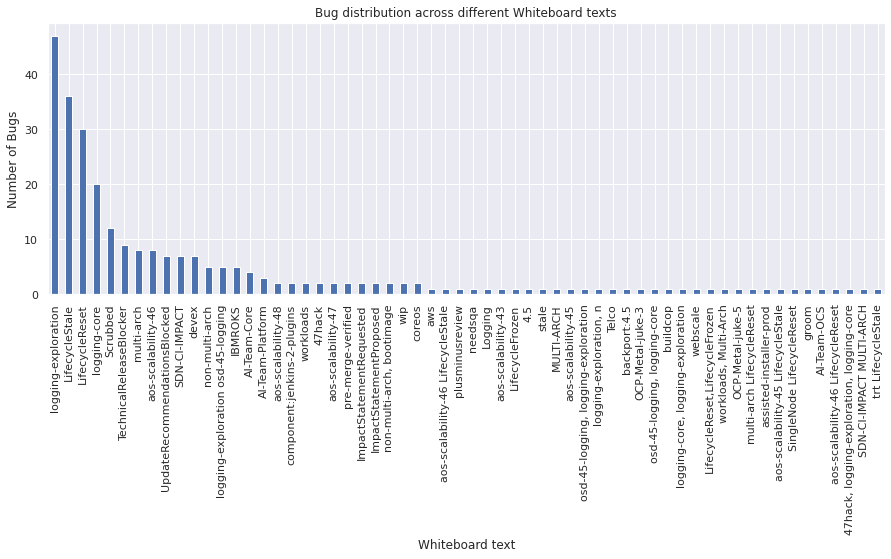

In [125]:
vc.plot.bar()
plt.xlabel("Whiteboard text")
plt.ylabel("Number of Bugs")
plt.title("Bug distribution across different Whiteboard texts")
plt.show()

### description 
This conatins descriptions for each bugzilla ticket.

In [126]:
bugs_df["description"]

0                                                     NaN
1       Description of problem:\nOn OCP 4.4.3, that wa...
2       Description of problem:\n\nThe bootstrap node ...
3                                                     NaN
4       Description of problem:\n\n1. On a 10 node clu...
                              ...                        
2952    Description of problem:\n4.7 to 4.6 downgrade ...
2953    Description of problem:\nTry to install "opens...
2954    Document URL: \n\nhttps://docs.openshift.com/c...
2955    Creating a new cluster on OpenShift 4.6 gets m...
2956    Description of problem:\n\nCustomer upgraded f...
Name: description, Length: 2957, dtype: object

In [127]:
print(bugs_df["description"].iloc[0])

nan


### resolution

In [128]:
vc = bugs_df["resolution"].value_counts()
vc

ERRATA               1109
DUPLICATE             282
NOTABUG               268
CURRENTRELEASE        104
WONTFIX                80
INSUFFICIENT_DATA      59
WORKSFORME             59
DEFERRED               48
EOL                    28
NEXTRELEASE            17
UPSTREAM               11
CANTFIX                 9
Name: resolution, dtype: int64

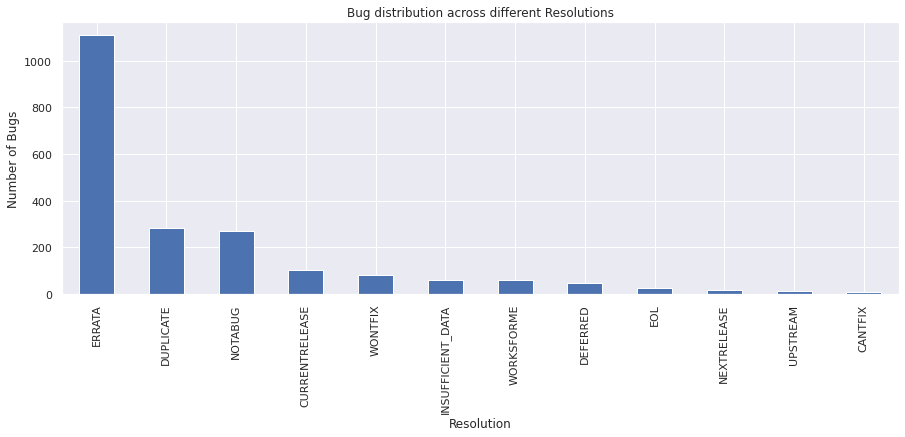

In [129]:
vc.plot.bar()
plt.xlabel("Resolution")
plt.ylabel("Number of Bugs")
plt.title("Bug distribution across different Resolutions")
plt.show()

From the above graph, we can infer that we have most values available for resolution, even though we have many values as empty, this looks like a promising parameter.

### cf_doc_type

In [130]:
vc = bugs_df["cf_doc_type"].value_counts()
vc

If docs needed, set a value    2188
No Doc Update                   375
Bug Fix                         224
Enhancement                      13
Release Note                      8
Known Issue                       5
Removed functionality             2
Name: cf_doc_type, dtype: int64

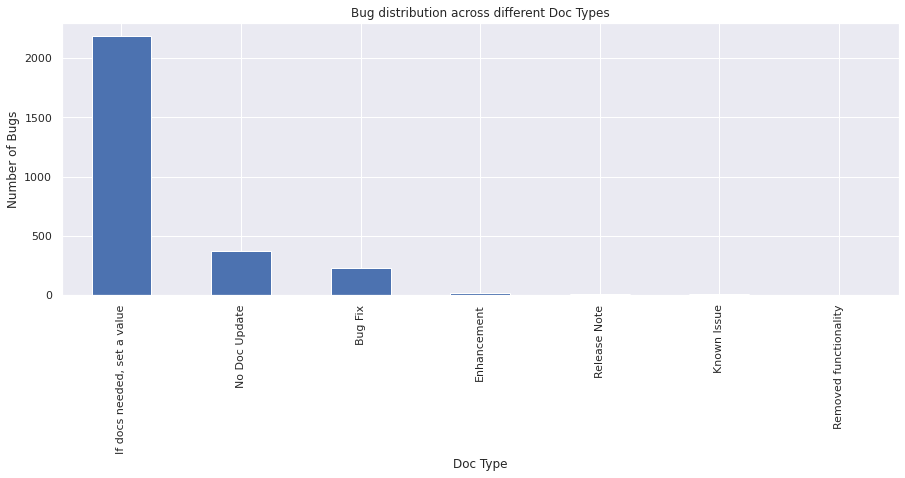

In [131]:
vc.plot.bar()
plt.xlabel("Doc Type")
plt.ylabel("Number of Bugs")
plt.title("Bug distribution across different Doc Types")
plt.show()

From the above graph, we see that most of the tickets have the value for `doc_type`. This could be used to classify the tickets according to the doc type.

### op_sys : Operating Systems

In [132]:
vc = bugs_df["op_sys"].value_counts()
vc

Unspecified    2419
Linux           333
All              59
Windows           2
Mac OS            2
Name: op_sys, dtype: int64

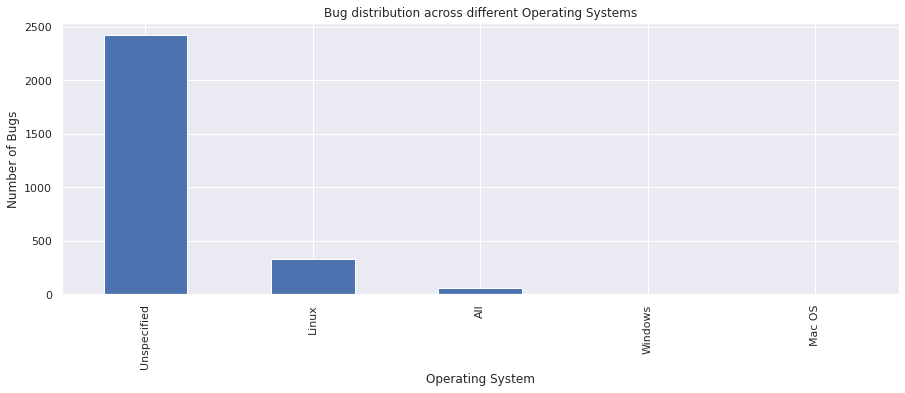

In [133]:
vc.plot.bar()
plt.xlabel("Operating System")
plt.ylabel("Number of Bugs")
plt.title("Bug distribution across different Operating Systems")
plt.show()

From the above graph, we can see that we have four OS(s) across the bugs.

### target_release

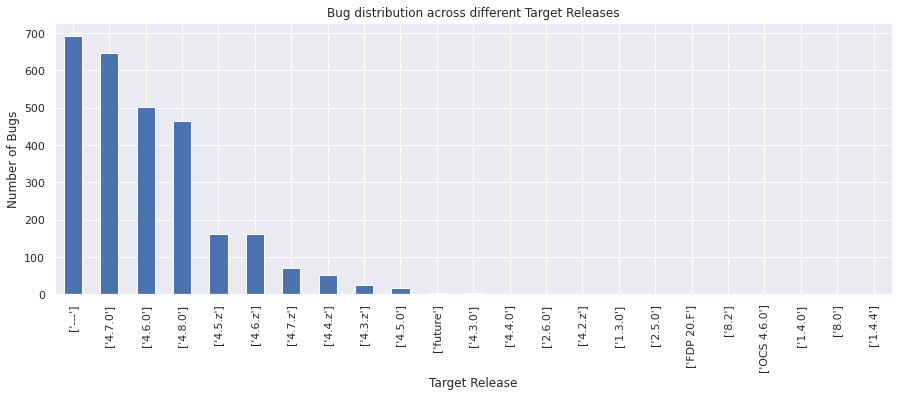

In [134]:
bugs_df["target_release"].value_counts().plot.bar()
plt.xlabel("Target Release")
plt.ylabel("Number of Bugs")
plt.title("Bug distribution across different Target Releases")
plt.show()

From the above graph, we see the various target releases frequency. This value also is mostly not assigned but we still have many observations.

### status

In [135]:
vc = bugs_df["status"].value_counts()
vc

CLOSED             2074
NEW                 218
VERIFIED            207
ASSIGNED            200
POST                 80
ON_QA                27
MODIFIED              7
RELEASE_PENDING       2
Name: status, dtype: int64

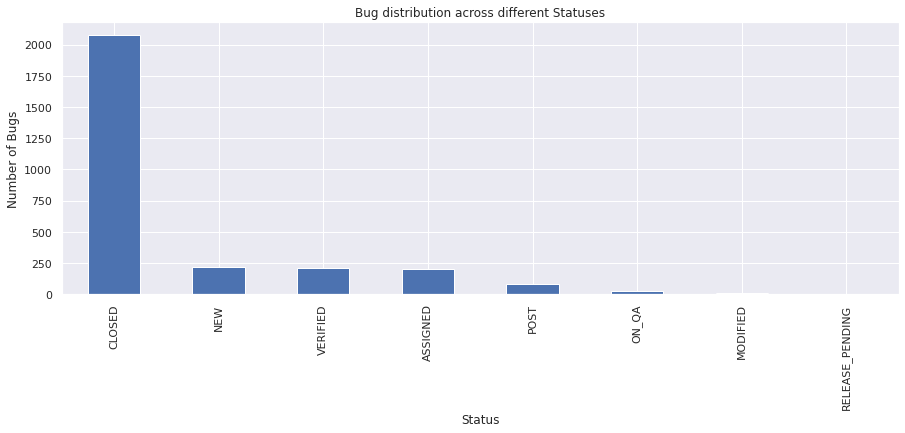

In [136]:
vc.plot.bar()
plt.xlabel("Status")
plt.ylabel("Number of Bugs")
plt.title("Bug distribution across different Statuses")
plt.show()

The above graph, shows various status across tickets.

### External Bugs

In [137]:
bugs_df["external_bugs"].value_counts().to_frame().head()

,external_bugs
[],1259
"[{'ext_description': 'Bug 1932114: Detect Nodes Network MTU', 'ext_bz_id': 131, 'ext_priority': 'None', 'bug_id': 1932114, 'ext_bz_bug_id': 'openshift/cluster-network-operator/pull/1070', 'id': 1781667, 'ext_status': 'open', 'type': {'must_send': False, 'can_send': False, 'description': 'Github', 'can_get': True, 'url': 'https://github.com/', 'id': 131, 'send_once': False, 'type': 'GitHub', 'full_url': 'https://github.com/%id%'}}, {'ext_description': 'Bug 1932114: Allow to config network MTU', 'ext_bz_id': 131, 'ext_priority': 'None', 'bug_id': 1932114, 'ext_bz_bug_id': 'openshift/kuryr-kubernetes/pull/506', 'id': 1781668, 'ext_status': 'open', 'type': {'must_send': False, 'can_send': False, 'description': 'Github', 'can_get': True, 'url': 'https://github.com/', 'id': 131, 'send_once': False, 'type': 'GitHub', 'full_url': 'https://github.com/%id%'}}]",1
"[{'ext_description': '[release-4.5] Bug 1880318: Update k8s version to v0.18.6', 'ext_bz_id': 131, 'ext_priority': 'None', 'bug_id': 1880318, 'ext_bz_bug_id': 'openshift/insights-operator/pull/284', 'id': 1702231, 'ext_status': 'closed', 'type': {'must_send': False, 'can_send': False, 'description': 'Github', 'can_get': True, 'url': 'https://github.com/', 'id': 131, 'send_once': False, 'type': 'GitHub', 'full_url': 'https://github.com/%id%'}}, {'ext_description': 'None', 'ext_bz_id': 139, 'ext_priority': 'None', 'bug_id': 1880318, 'ext_bz_bug_id': 'RHBA-2021:0033', 'id': 1724581, 'ext_status': 'None', 'type': {'must_send': False, 'can_send': False, 'description': 'Red Hat Product Errata', 'can_get': False, 'url': 'https://access.redhat.com/errata/', 'id': 139, 'send_once': False, 'type': 'None', 'full_url': 'https://access.redhat.com/errata/%id%'}}]",1
"[{'ext_description': 'None', 'ext_bz_id': 139, 'ext_priority': 'None', 'bug_id': 1915007, 'ext_bz_bug_id': 'RHSA-2021:0037', 'id': 1723319, 'ext_status': 'None', 'type': {'must_send': False, 'can_send': False, 'description': 'Red Hat Product Errata', 'can_get': False, 'url': 'https://access.redhat.com/errata/', 'id': 139, 'send_once': False, 'type': 'None', 'full_url': 'https://access.redhat.com/errata/%id%'}}]",1
"[{'ext_description': 'None', 'ext_bz_id': 139, 'ext_priority': 'None', 'bug_id': 1880354, 'ext_bz_bug_id': 'RHBA-2020:4196', 'id': 1641543, 'ext_status': 'None', 'type': {'must_send': False, 'can_send': False, 'description': 'Red Hat Product Errata', 'can_get': False, 'url': 'https://access.redhat.com/errata/', 'id': 139, 'send_once': False, 'type': 'None', 'full_url': 'https://access.redhat.com/errata/%id%'}}]",1


### platform

The `platform` field indicates the hardware platform the bug was observed on.

In [138]:
vc = bugs_df["platform"].value_counts()
vc

Unspecified    2381
x86_64          249
All             126
s390x            36
ppc64le          22
ppc64             1
Name: platform, dtype: int64

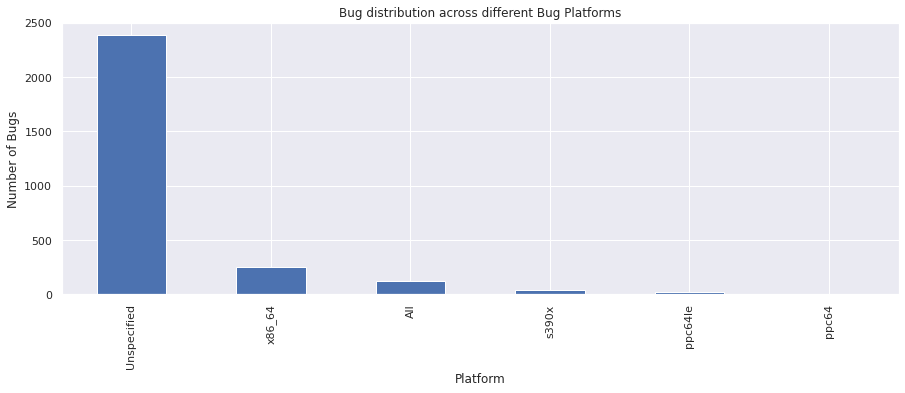

In [139]:
vc.plot(kind="bar")
plt.xlabel("Platform")
plt.ylabel("Number of Bugs")
plt.title("Bug distribution across different Bug Platforms")
plt.show()

### severity

The `severity` field categorzies the severity level of each bug. Let's see the different severity levels defined. Let's plot a simple graph to visualize the distribution of bug severities

In [140]:
vc = bugs_df["severity"].value_counts()
vc

high           1011
medium          962
urgent          350
low             329
unspecified     163
Name: severity, dtype: int64

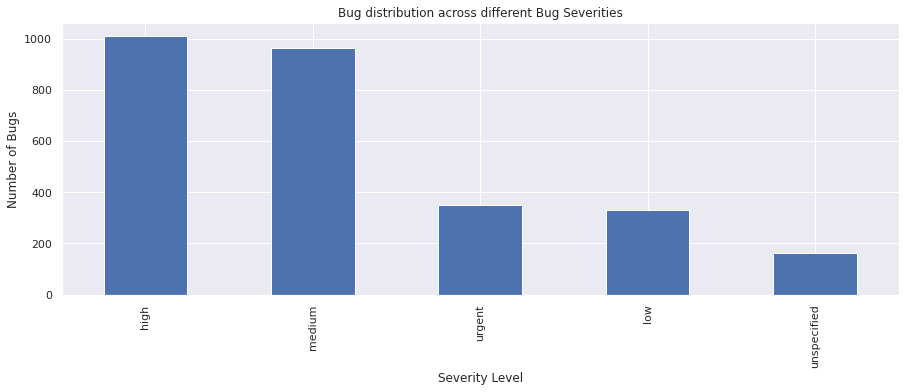

In [141]:
vc.plot(kind="bar")
plt.xlabel("Severity Level")
plt.ylabel("Number of Bugs")
plt.title("Bug distribution across different Bug Severities")
plt.show()

### cf_environment

Not too sure what `cf_environment` is supposed to return

In [142]:
bugs_df["cf_environment"].value_counts().to_frame()

,cf_environment
Undiagnosed panic detected in pod,13
[sig-cluster-lifecycle] cluster upgrade should be fast,4
[sig-arch] Managed cluster should have no crashlooping pods in core namespaces over four minutes [Suite:openshift/conformance/parallel],4
test: operator,3
[sig-arch][Feature:ClusterUpgrade] Cluster should remain functional during upgrade [Disruptive] [Serial],3
...,...
[sig-network][Feature:Router] The HAProxy router should expose prometheus metrics for a route,1
[sig-network-edge][Conformance][Area:Networking][Feature:Router] The HAProxy router should pass the h2spec conformance tests [Suite:openshift/conformance/parallel/minimal],1
operator.Run multi-stage test e2e-ovirt - e2e-ovirt-ipi-install-install container test,1
[sig-scheduling] Multi-AZ Clusters should spread the pods of a replication controller across zones,1


### version

The `version` field indicates the version of the software the bug was found in. Let's plot a simple graph to visualize the distribution of bugs across different software versions.

In [143]:
vc = bugs_df["version"].value_counts()
vc

4.6             821
4.5             617
4.7             601
4.8             240
4.4             234
4.6.z           117
4.3.z            79
4.3.0            41
4.2.0            22
4.2.z            17
2.5.0             6
unspecified       3
1.3.0             3
2.4.0             2
8.2               2
RHEL 8.0          1
FDB 18.11         1
rhacm-1.0.z       1
2.6.1             1
FDP 20.E          1
16.1 (Train)      1
FDP 20.F          1
rhacm-2.2.z       1
2.3.0             1
2.4.1             1
Name: version, dtype: int64

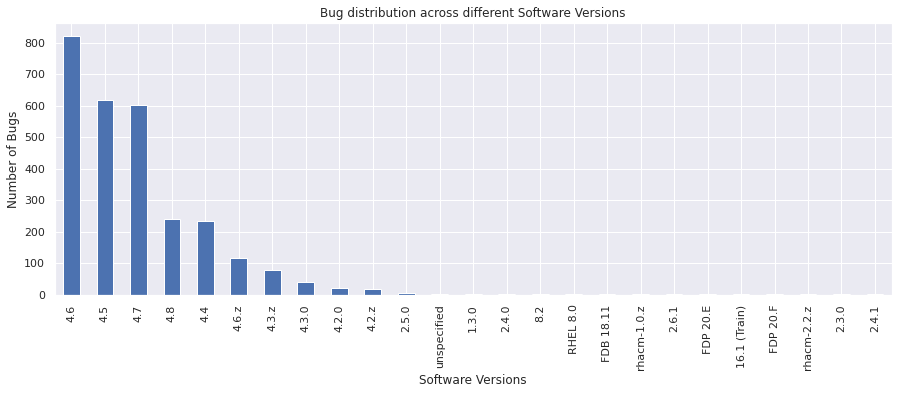

In [144]:
vc.plot(kind="bar")
plt.ylabel("Number of Bugs")
plt.xlabel("Software Versions")
plt.title("Bug distribution across different Software Versions")
plt.show()

### component

Bugs are categorised into Product and Component. Components are second-level categories and the `component` field indicates which component is affected by the bug.

In [145]:
vc = bugs_df["component"].value_counts()
vc

Networking                 374
Node                       178
Storage                    169
OLM                        157
Machine Config Operator    147
                          ... 
DPDK                         1
Eventing                     1
OVN                          1
SSP                          1
Templates                    1
Name: component, Length: 82, dtype: int64

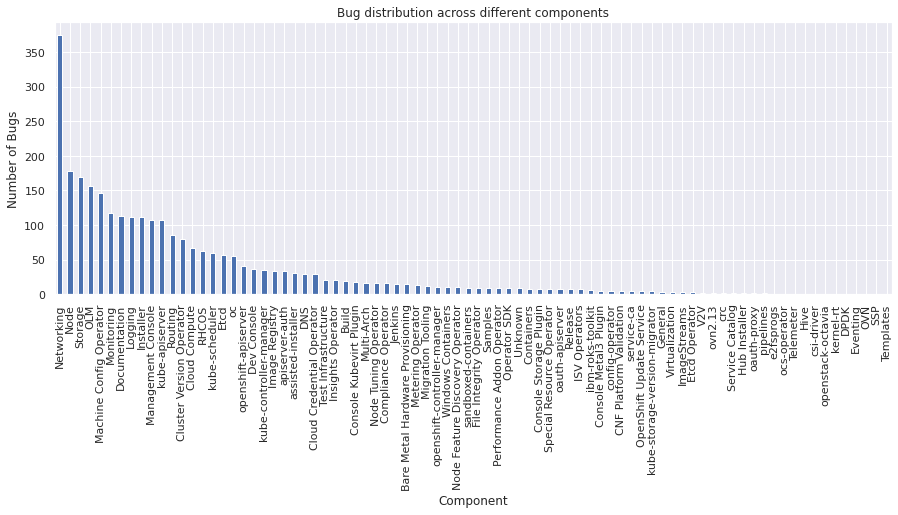

In [146]:
vc.plot(kind="bar")
plt.xlabel("Component")
plt.ylabel("Number of Bugs")
plt.title("Bug distribution across different components")
plt.show()

### sub_component

The `sub_component` field indicates the sub-component of a specifc component the bug affects.

In [147]:
vc = bugs_df["sub_component"].value_counts()
vc

ovn-kubernetes                    145
openshift-sdn                     143
OLM                               137
Kubelet                            86
Operators                          64
CRI-O                              48
openshift-installer                47
Other Providers                    45
kuryr                              37
Kubernetes                         24
Storage                            22
OpenShift on RHV                   21
assisted-service                   21
multus                             20
SR-IOV                             20
OperatorHub                        20
OpenShift on OpenStack             19
OpenShift on Bare Metal IPI        16
OpenStack CSI Drivers              15
Local Storage Operator             13
Autoscaler (HPA, VPA)              12
oVirt CSI Driver                    9
cluster-baremetal-operator          7
Kubernetes External Components      7
OpenStack Provider                  7
ironic                              6
oVirt Provid

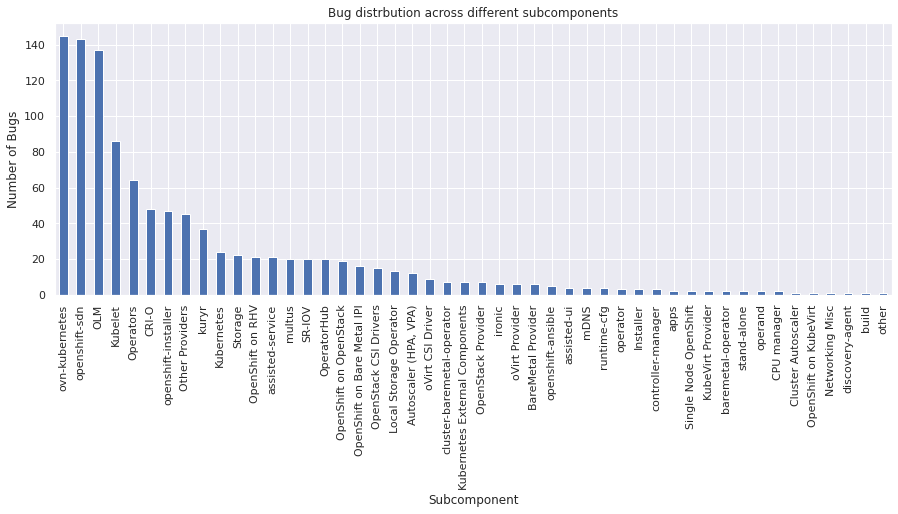

In [148]:
vc.plot(kind="bar")
plt.xlabel("Subcomponent")
plt.ylabel("Number of Bugs")
plt.title("Bug distrbution across different subcomponents")
plt.show()

### product

The `product` field indicates the software product affected by the bug.

In [149]:
vc = bugs_df["product"].value_counts()
vc

OpenShift Container Platform                          2787
Container Native Virtualization (CNV)                   11
Red Hat Enterprise Linux Fast Datapath                   4
Migration Toolkit for Containers                         3
Red Hat Advanced Cluster Management for Kubernetes       2
Red Hat OpenShift Pipelines                              2
Red Hat OpenShift Container Storage                      2
Red Hat Enterprise Linux 8                               2
OpenShift Serverless                                     1
Red Hat OpenStack                                        1
Name: product, dtype: int64

Let's plot a simple graph to visualize the distribution of bugs across different products

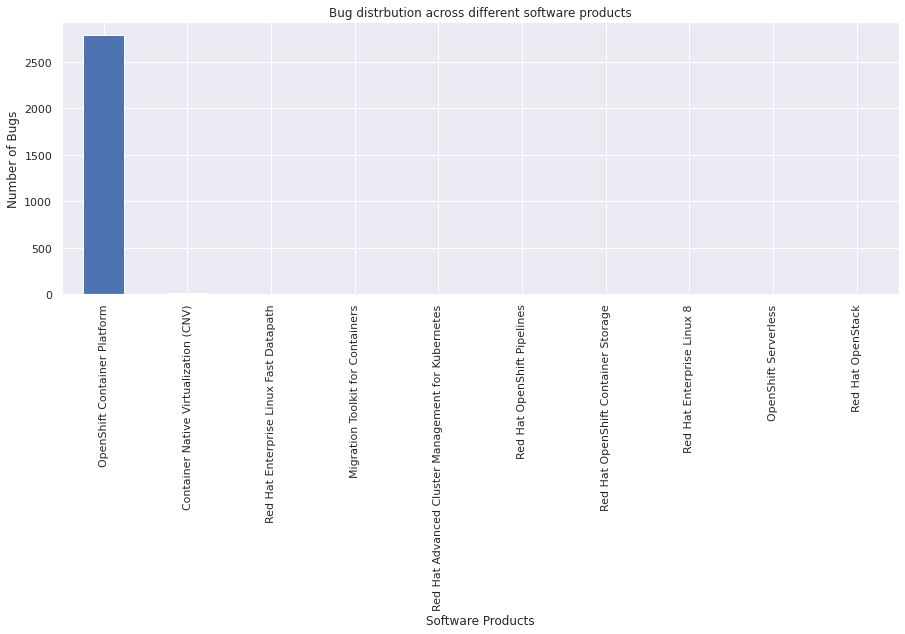

In [150]:
vc.plot(kind="bar")
plt.xlabel("Software Products")
plt.ylabel("Number of Bugs")
plt.title("Bug distrbution across different software products")
plt.show()

### fixed_in

In [151]:
bugs_df["fixed_in"][:15]

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     NaN
7     NaN
8     NaN
9     NaN
10    NaN
11    NaN
12    NaN
13    NaN
14    NaN
Name: fixed_in, dtype: object

In [152]:
bugs_df["fixed_in"].unique()

array([nan, 'assisted-ui-lib v0.0.13-wizard',
       'cri-o-1.20.2, openshift 4.7.4', 'jkaur@redhat.com',
       'OCP-Metal-v1.0.18.2', 'runc-1.0.0-82.rhaos4.6.git086e841.el8',
       'podman-1.6.4-11.rhaos4.3.el8', 'OCP-Metal-v1.0.12.1', '2.5.0',
       'v0.1.10', '4.8', 'cri-o-1.19.0-62.rhaos4.6.git10c7a86.el8',
       '4.6.4', 'podman-1.9.3-1.rhaos4.6.el8', 'OCP-Metal-V1.0.17.3',
       '4.7.0-0.nightly-2020-12-17-001141',
       'runc-1.0.0-81.rhaos4.6.git5b757d4', 'OCP-Metal-v1.0.9.5',
       'milei@redhat.com , annair@redhat.com',
       'runc-1.0.0-67.rc10.rhaos4.3.el7', 'OCP-Metal-v1.0.18.1',
       'annair@redhat.com, milei@redhat.com', 'facet-lib v1.4.9',
       'virt-cdi-importer 2.6.0-15'], dtype=object)

The `fixed_in` field seems to indicate the software version the bug was fixed in. However, it doesn't seem to be applicable to all bugs as some bugs may still be open and not yet resolved.

### summary

The bug summary is a short sentence which succinctly describes what the bug is about.

In [153]:
bugs_df["summary"]

0                                                     NaN
1       OCP nodes with low disk space after ~20-40 day...
2       [OSP] Bootstrap and master nodes use different...
3                                                     NaN
4       ovnkube-node/ovn-controller does not scale - r...
                              ...                        
2952    4.7 to 4.6 downgrade stuck at openshift-apiser...
2953    "installed" operator status in operatorhub pag...
2954    Need new section to address horizontal-pod-aut...
2955        New version of OCP 4.6 uses unreleased kernel
2956    Upgrade to OCP 4.6.9 results in cluster-wide D...
Name: summary, Length: 2957, dtype: object

In [154]:
print(bugs_df["summary"].iloc[0])

nan


### is_open

In [155]:
vc = bugs_df["is_open"].value_counts()
vc

False    2074
True      741
Name: is_open, dtype: int64

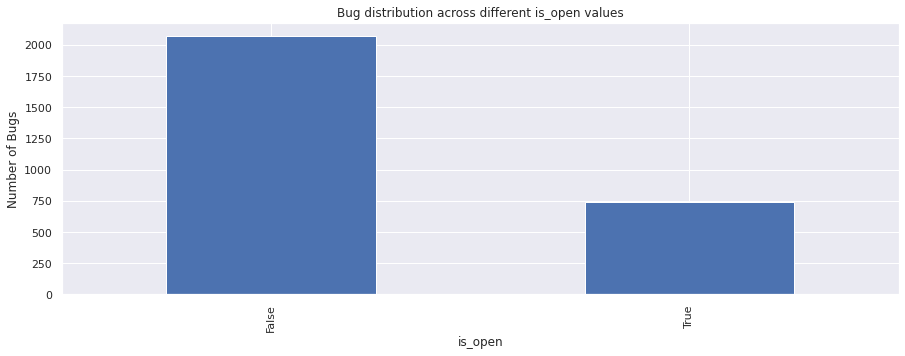

In [156]:
vc.plot.bar()
plt.xlabel("is_open")
plt.ylabel("Number of Bugs")
plt.title("Bug distribution across different is_open values")
plt.show()

## Contact Metadata

These fields contain information for people responsible for QA, creation of bug, etc. These are not useful for the initial EDA.

- `docs_contact_value` and `qa_contact`: The people responsible for contacting and fixing the bug.
- `creator`: The person who created the bug.
- `assigned_to`: The person responsible for fixing the bug.
- `cc`: The mailing list subscribed to get updates for a bug.

## Non Useful Metadata

These fields mostly had either the same value or empty. Therefore, these are not useful for our analysis.

- `tags`: The tags field seems to be empty for most bugs so we can probably ignore this field.
- `flags`: The flags field seems to return empty for most bugs. For thos bugs which have this field set, it seems to have redundant information which are already available in other bug fields so we can probably ignore this field.
- `is_creator_accessible`: The is_creator_accessible field returns a boolean value, but doesn't seem to be useful for our analysis.
- `cf_release_notes`: The cf_release_notes is the basis of the errata or release note for the bug. It can also be used for change logs. However, it seems to be empty for most bugs and can be excluded from our analysis.
- `target_milestone`: The target_milestone is used to define when the engineer the bug is assigned to expects to fix it. However, it doesn't seem to be applicable for most bugs.
- `is_confirmed`: The is_confirmed field seems to return a boolean value (not sure what it indicates) and doesn't seem to be useful for our analysis.
- `components`: The components field returns the same values as the component field, but in a list format.
- `sub_components` - The sub_components field is similar to the sub_component field, but returns both the component and sub-component affected by the bug in a dictionary format.
- `versions`: The versions field returns the same values as the version field, but in a list format.

# Conclusion

In this notebook, we show how the bug ids related to each test under each job for all dashboards can be determined, and saved a sample of this mapping as the linked-bugs dataset. We also showed how detailed information for a set of bug ids can be collected, and saved a sample of this dataset as the bug-details dataset. These datasets open up several avenues for exploration, such as in-depth bugs data EDA, and EDA for testgrid + bugs datasets put together, which we will explore in future notebooks.